In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp

In [146]:
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
pot = gp.load('../output/mwpot.yml')

In [2]:
t = Table.read('../data/gd1-all-ps1-red.fits')

# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for band in bands:
    t[band] = t[band] - t['A_{}'.format(band)]

g = GaiaData(t)
c = g.get_skycoord(distance=False)

In [515]:
# iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
iso = Table.read('../data/mist_12.6_-1.80.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

Use Koposov's orbit fit to improve selection:

In [516]:
phi1_0 = 20. * u.deg
phi2, d, pm1, pm2, vr = [-3.47508128, 12.26167861, -5.70045271, -1.44728289, -326.96300355]
c0 = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
            pm_phi1_cosphi2=pm1*u.mas/u.yr,
            pm_phi2=pm2*u.mas/u.yr,
            radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c0.transform_to(gc_frame).cartesian)

In [517]:
orbit = pot.integrate_orbit(w0, dt=-0.2*u.Myr, n_steps=100)
orbit = pot.integrate_orbit(orbit[-1], dt=0.2*u.Myr, n_steps=500)
orbit_c = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
orbit_gd1 = gc.reflex_correct(orbit_c)

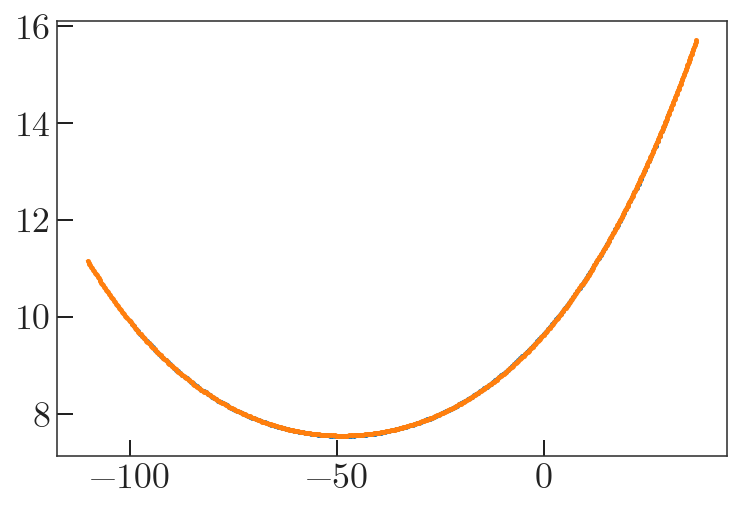

In [518]:
dist_coeffs = np.polyfit(orbit_gd1.phi1.wrap_at(180*u.deg).degree, 
                         orbit_gd1.distance.value, 
                         4)

grid = np.linspace(-100, 30, 256)
dist = np.polyval(dist_coeffs, grid)

plt.plot(grid, dist)
plt.plot(orbit_gd1.phi1.wrap_at(180*u.deg), 
         orbit_gd1.distance)

In [519]:
def gd1_k10_dist(phi1):
    phi1 = coord.Angle(phi1)
    return coord.Distance(np.polyval(dist_coeffs, phi1.wrap_at(180*u.deg).degree) * u.kpc)

In [520]:
c_gd1 = c.transform_to(gc.GD1)
phi1 = c_gd1.phi1.wrap_at(180*u.deg)
est_dist = gd1_k10_dist(phi1)

c_dist = g.get_skycoord(distance=est_dist, radial_velocity=0*u.km/u.s)
c_gd1 = c_dist.transform_to(gc.GD1)
gd1 = gc.reflex_correct(c_gd1)

In [521]:
points_gi = np.array([g.g - g.i, g.g]).T
points_rz = np.array([g.r - g.z, g.r]).T

In [522]:
phi1 = gd1.phi1.wrap_at(180*u.deg)

In [523]:
gig_bins = (np.linspace(-1, 1, 64),
            np.linspace(15, 21, 128))

pm_bins = (np.linspace(-15, 5, 51),
           np.linspace(-10, 10, 51))

phi1_bins = np.arange(-110, 50+1, 5) * u.deg

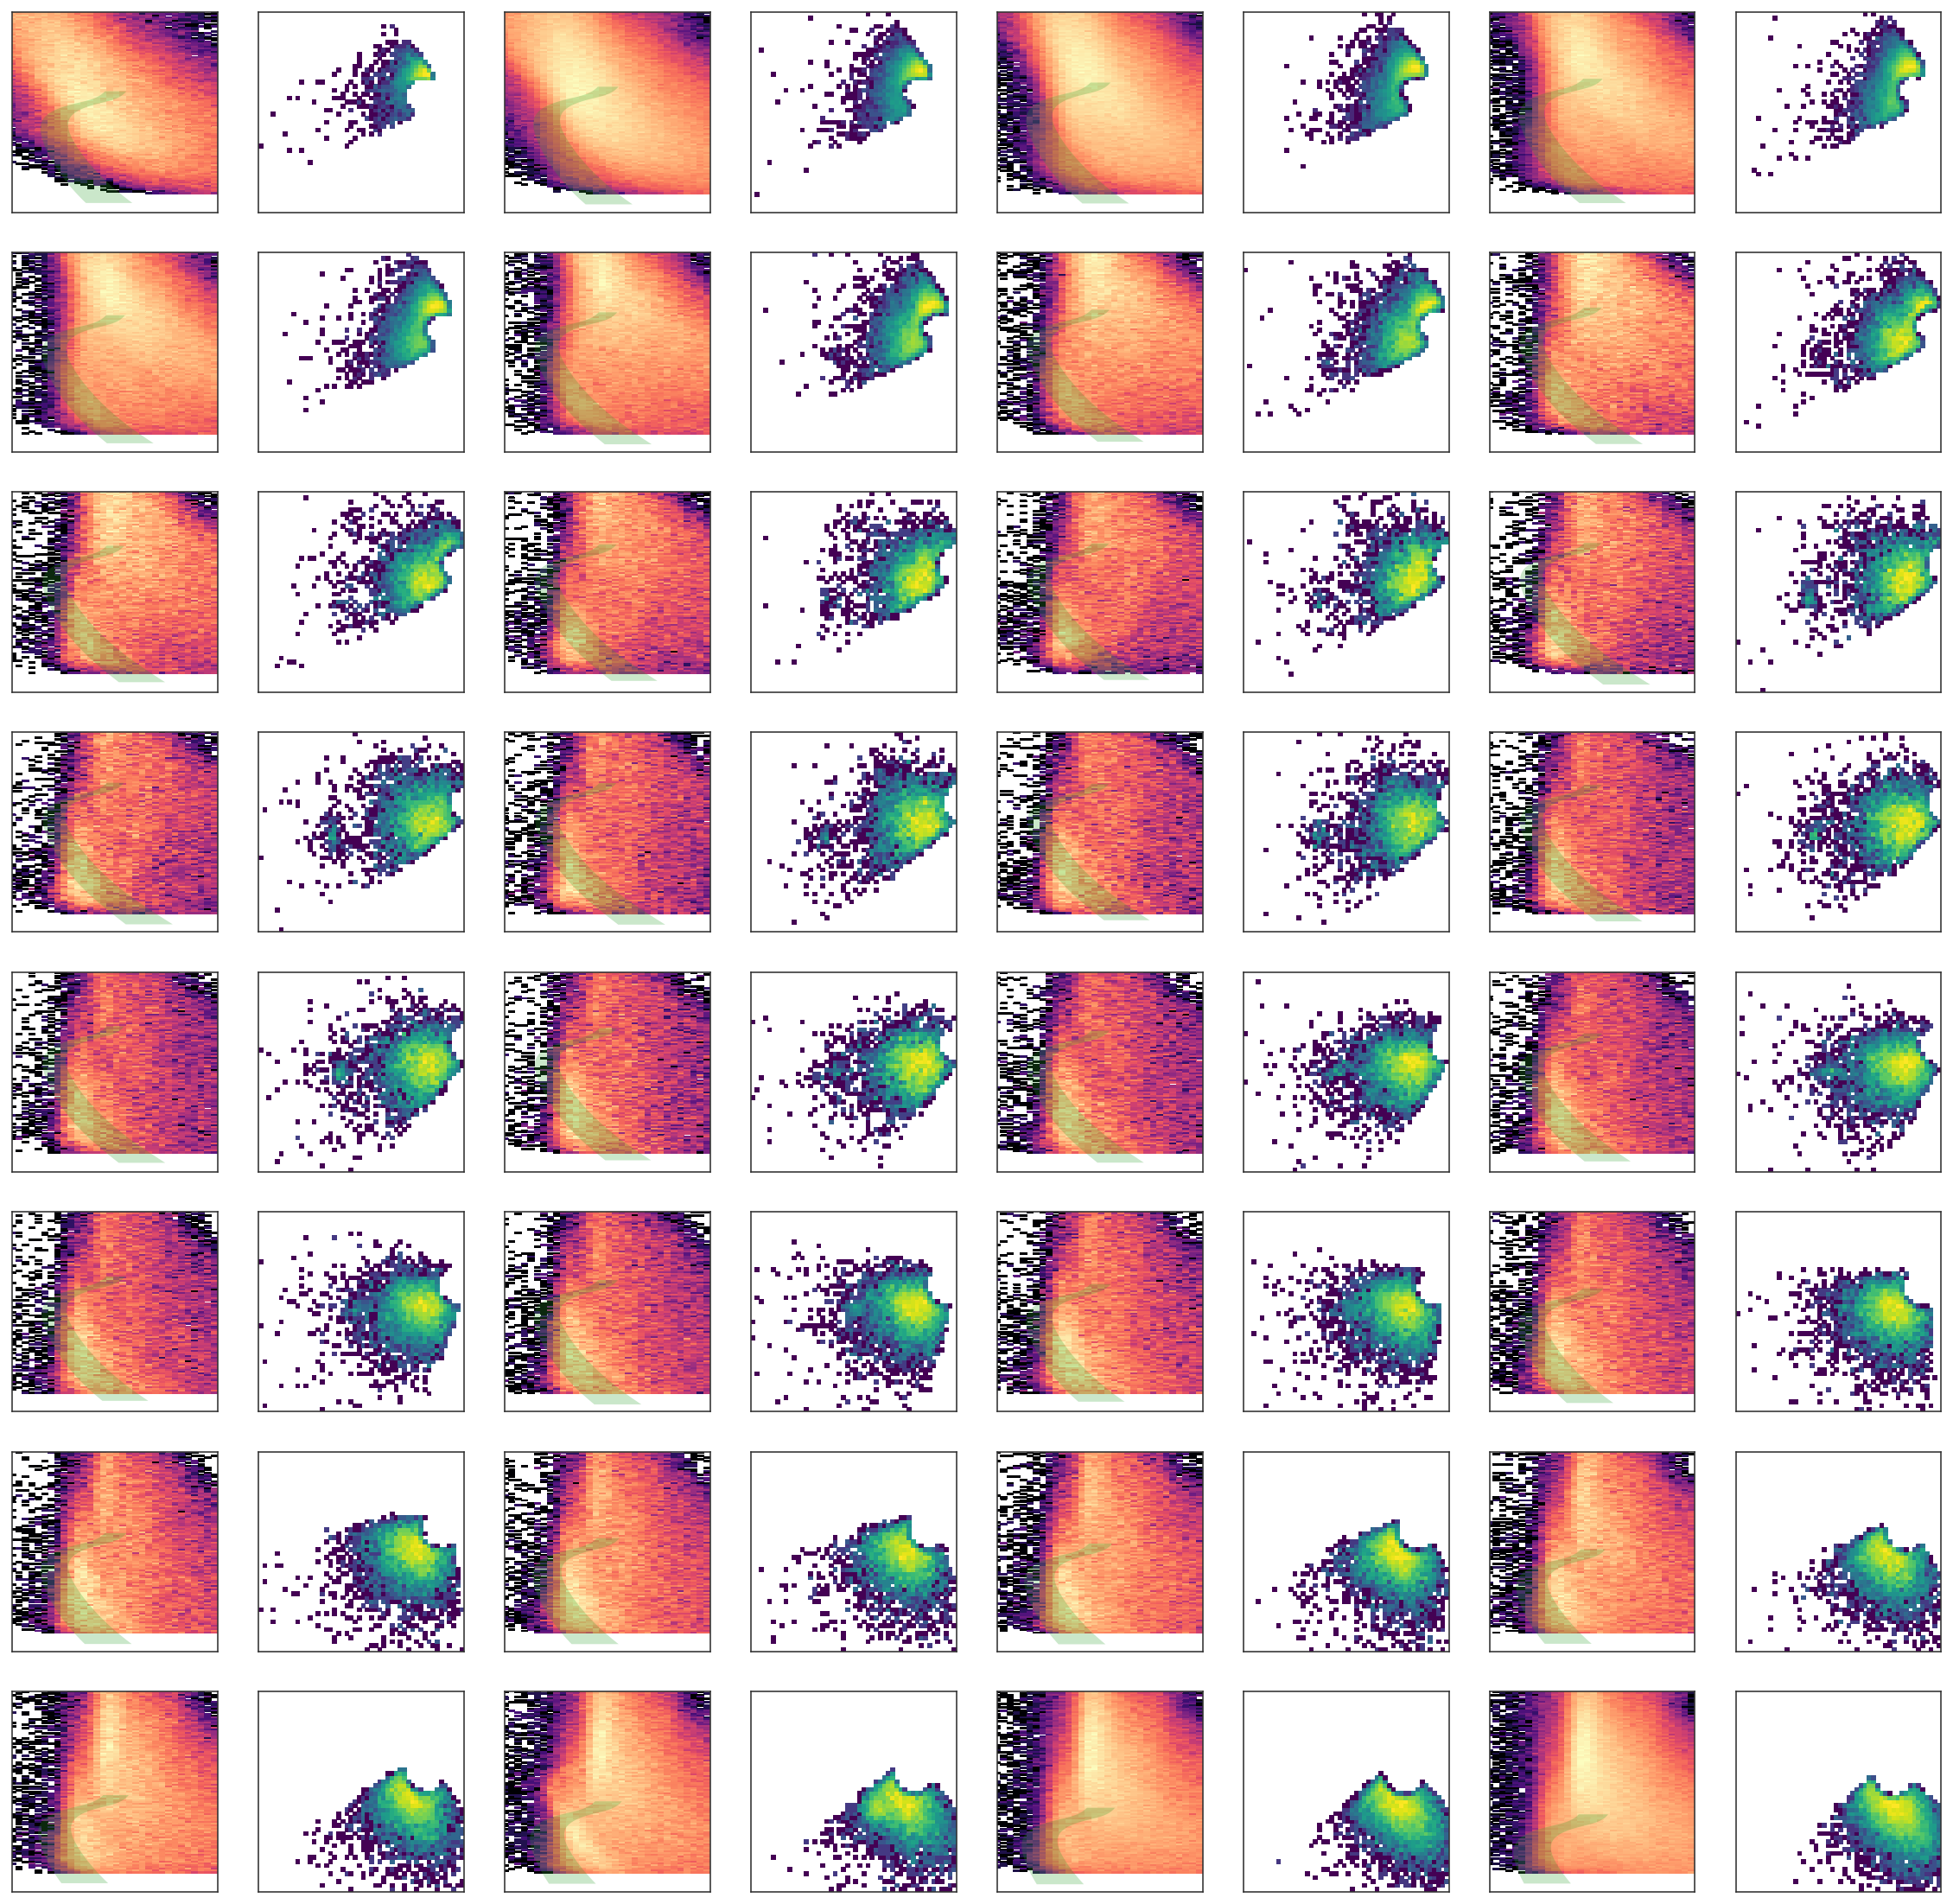

In [524]:
plot = True

all_cmd_mask = np.zeros(len(g)).astype(bool)

if plot:
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))

l_bins = phi1_bins[:-1]
r_bins = phi1_bins[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    DM = gd1_k10_dist(0.5 * (l+r)).distmod.value
    
    # main sequence + rgb mask
    # g-i vs g
    i_gi = iso['PS_g']-iso['PS_i']
    i_g = iso['PS_g'] + DM
    gi_left = i_gi - 0.4*(i_g/28)**5
    gi_right = i_gi + 0.5*(i_g/28)**5
    
    # r-z vs r
    i_rz = iso['PS_r']-iso['PS_z']
    i_r = iso['PS_r'] + DM
    rz_left = i_rz - 0.4*(i_r/28)**5
    rz_right = i_rz + 0.5*(i_r/28)**5

    poly = np.hstack([np.array([gi_left, i_g]), np.array([gi_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1] < 21.3) & (poly[:,1] > (3+DM))
    poly_main_gi = poly[ind]
    cmd_mask_gi = mpl.path.Path(poly_main_gi).contains_points(points_gi)
    
    poly = np.hstack([np.array([rz_left, i_r]), np.array([rz_right[::-1], i_r[::-1]])]).T
    ind = (poly[:,1]<21.3) & (poly[:,1]>(2+DM))
    poly_main_rz = poly[ind]
    cmd_mask_rz = mpl.path.Path(poly_main_rz).contains_points(points_rz)
    
    all_cmd_mask = all_cmd_mask | (phi1_mask & cmd_mask_gi & cmd_mask_rz)
    
    if plot:
        ax1 = axes.flat[2*j]
        ax2 = axes.flat[2*j+1]
    
    #     ax1.plot(points_gi[phi1_mask, 0], points_gi[phi1_mask, 1], 
    #              marker=',', alpha=0.25, ls='none', color='k')
        H, xe, ye = np.histogram2d(points_gi[phi1_mask, 0], 
                                   points_gi[phi1_mask, 1],
                                   bins=gig_bins)
        ax1.pcolormesh(xe, ye, H.T, 
                       norm=mpl.colors.LogNorm(), cmap='magma')

        pm = mpl.patches.Polygon(poly_main_gi, color='tab:green', alpha=0.25, 
                                 zorder=2, label='', linewidth=0)
        ax1.add_artist(pm)

        # --------------------------------
        # Proper motions for cmd-filtered:

        full_mask = cmd_mask_gi & cmd_mask_rz & phi1_mask
    #     ax2.plot(gd1.pm_phi1_cosphi2[full_mask].value,
    #              gd1.pm_phi2[full_mask].value,
    #              marker='.', alpha=0.4, ls='none', color='k')
        H, xe, ye = np.histogram2d(gd1.pm_phi1_cosphi2[full_mask].value,
                                   gd1.pm_phi2[full_mask].value,
                                   bins=pm_bins)
        ax2.pcolormesh(xe, ye, H.T, 
                       norm=mpl.colors.LogNorm(), cmap='viridis')

        # ------------------
        # Limits and labels:

        ax1.set_xlim(0, 1)
        ax1.set_ylim(21.5, 16)

        ax2.set_xlim(-15, 5)
        ax2.set_ylim(-10, 10)

        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)

        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)

    #     break

In [525]:
# np.save('../output/cmd_gi_rz_mask.npy', all_cmd_mask)

In [526]:
all_cmd_mask.sum()

187850

In [527]:
ctl_mask = (c_gd1.phi2 > 2*u.deg) | (c_gd1.phi2 < -5.5*u.deg)
gd1_mask = (c_gd1.phi2 < 2*u.deg) & (c_gd1.phi2 > -5.5*u.deg)

In [528]:
pm_bins = (np.arange(-15, 5+1e-3, 0.4),
           np.arange(-10, 10+1e-3, 0.4))

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:48: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in less


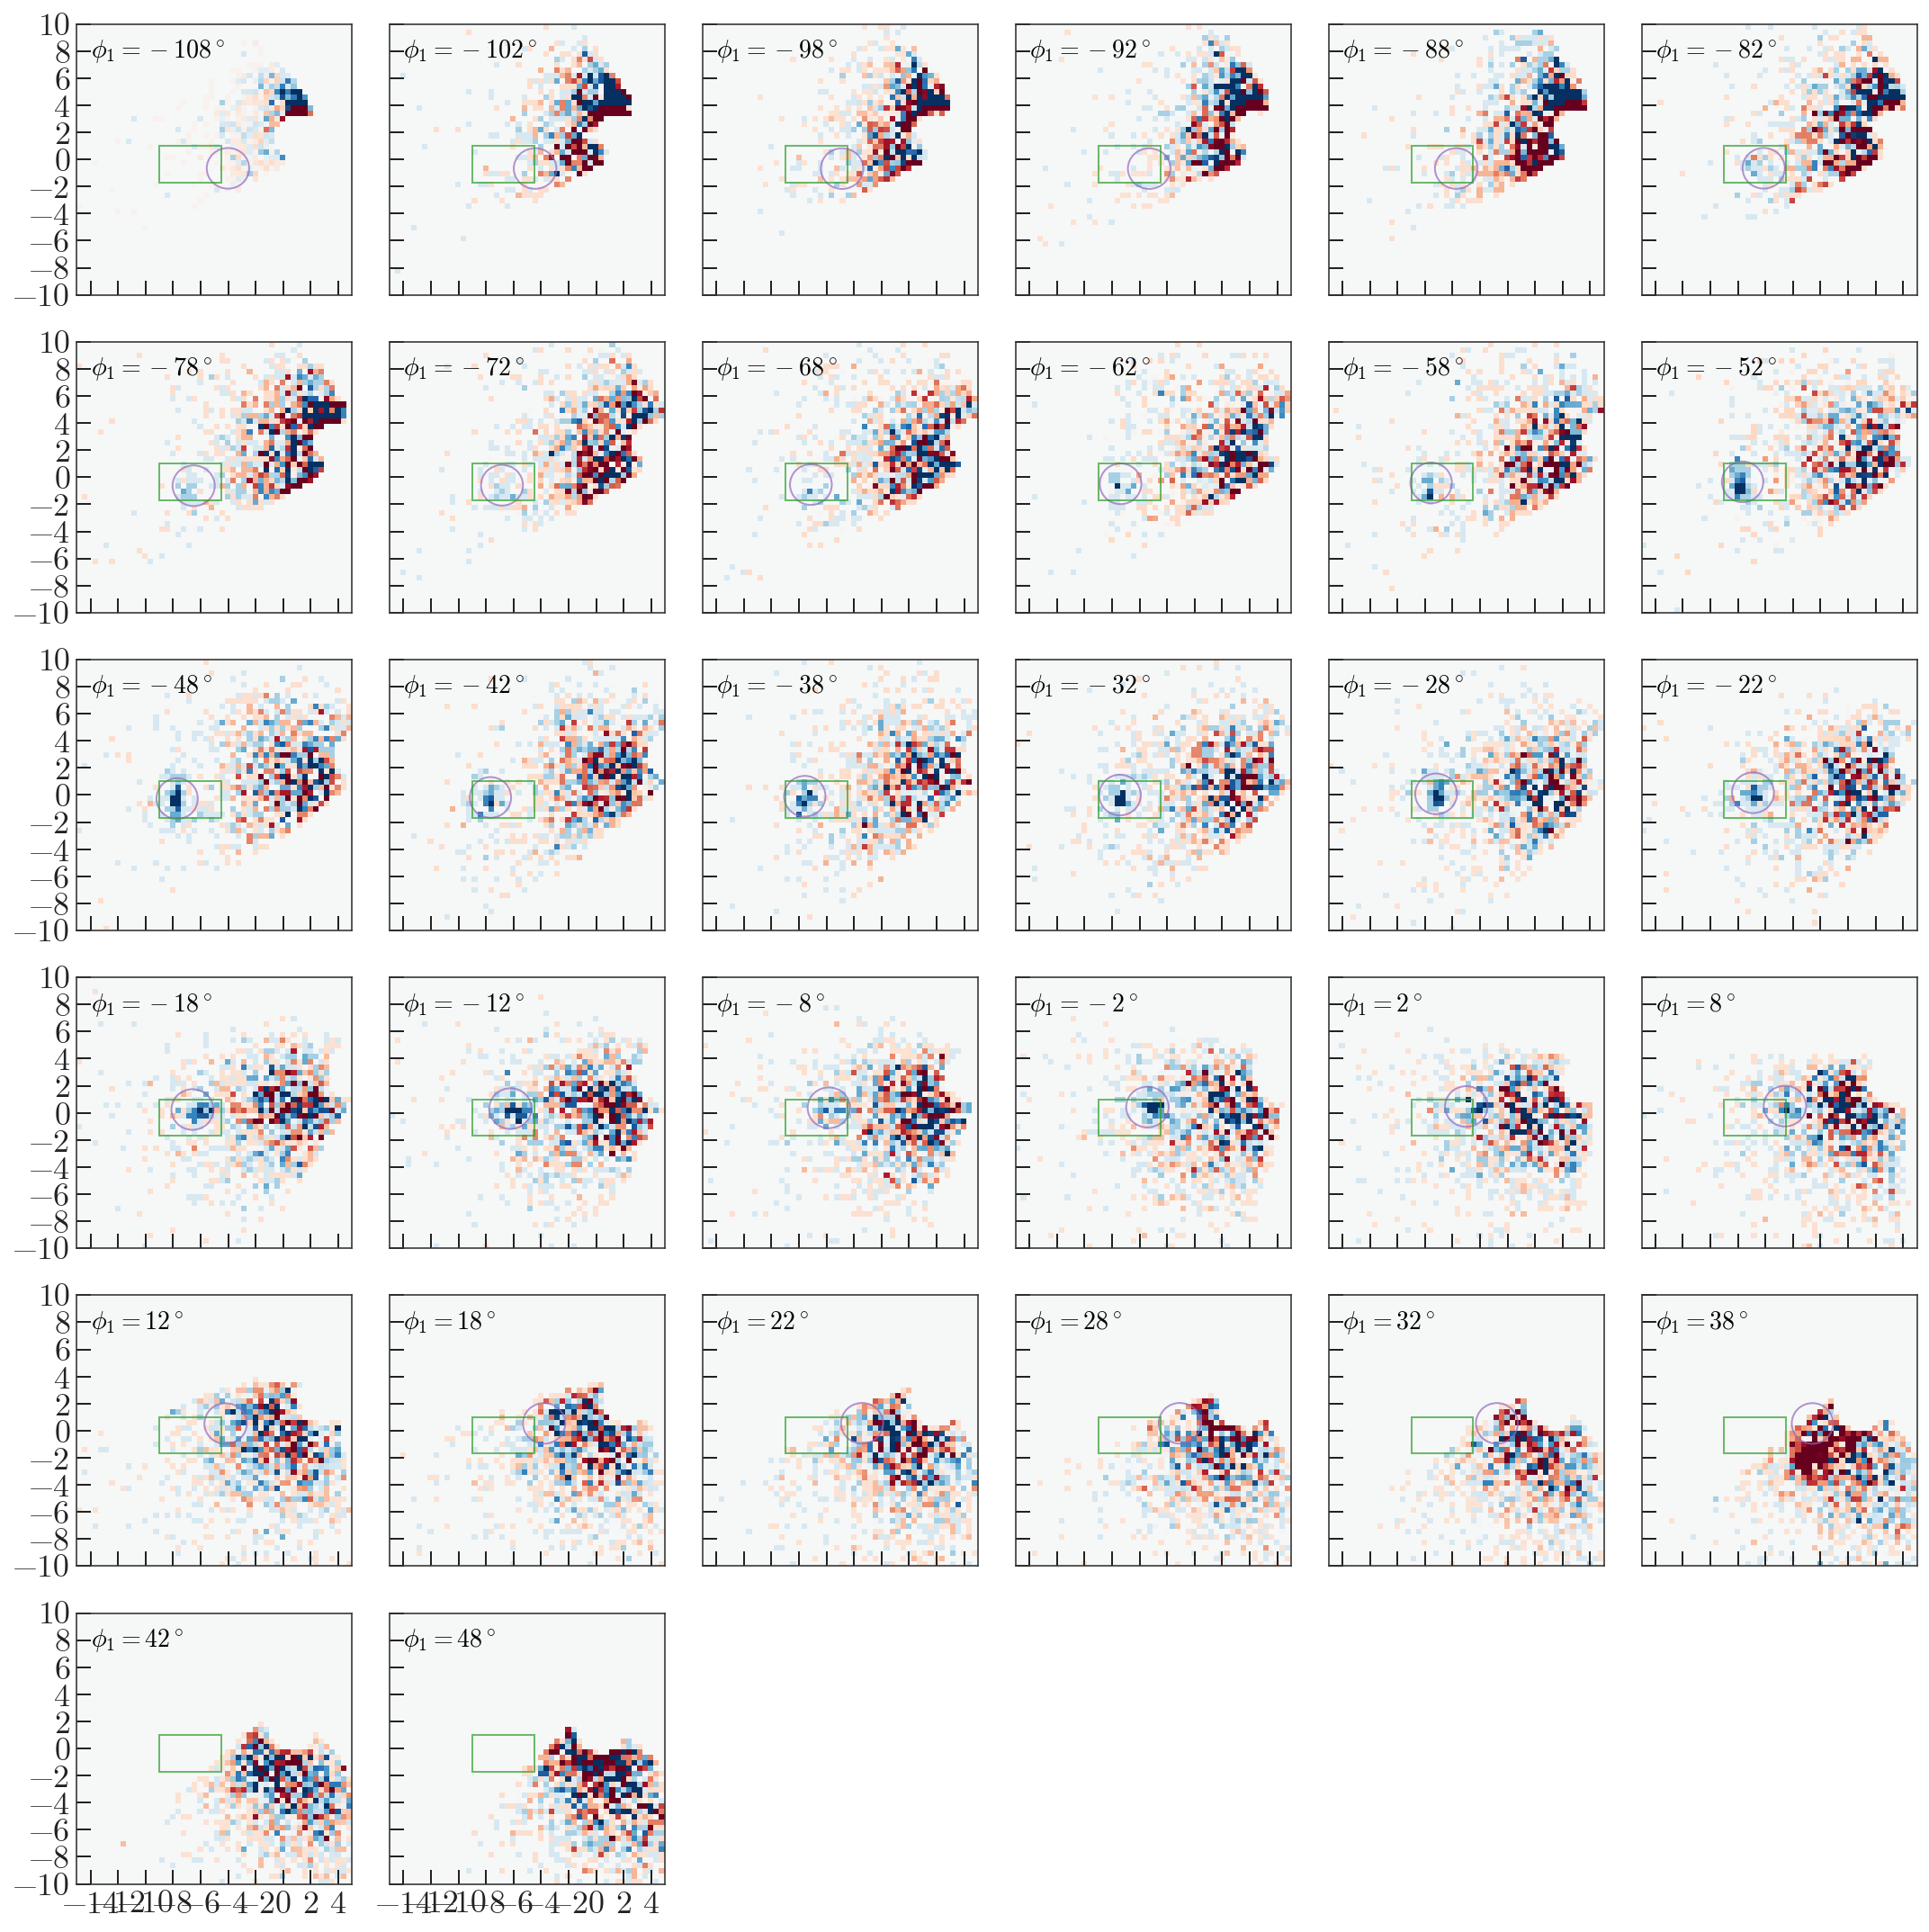

In [529]:
pm1 = gd1.pm_phi1_cosphi2.value
pm2 = gd1.pm_phi2.value
pmX = np.vstack((pm1, pm2)).T

fig, axes = plt.subplots(6, 6, figsize=(15, 15),
                         sharex=True, sharey=True)

pm_mask = np.zeros(len(g)).astype(bool)

l_bins = phi1_bins[:-1]
r_bins = phi1_bins[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    orbit_phi1_mask = (orbit_gd1.phi1.wrap_at(180*u.deg) >= l) & (orbit_gd1.phi1.wrap_at(180*u.deg) < r)
    ax = axes.flat[j]
    
    this_ctl_mask = all_cmd_mask & phi1_mask & ctl_mask
    this_gd1_mask = all_cmd_mask & phi1_mask & gd1_mask
    # print(this_ctl_mask.sum(), this_gd1_mask.sum())
    
    H_ctl, xe, ye = np.histogram2d(pm1[this_ctl_mask],
                                   pm2[this_ctl_mask],
                                   bins=pm_bins)
    
    H_gd1, xe, ye = np.histogram2d(pm1[this_gd1_mask],
                                   pm2[this_gd1_mask],
                                   bins=pm_bins)
    
    norm_mask = gd1.pm_phi1_cosphi2 > 0
    n_ctl = (norm_mask & this_ctl_mask).sum()
    n_gd1 = (norm_mask & this_gd1_mask).sum()
    H_ctl *= n_gd1 / n_ctl
    
    ax.pcolormesh(xe, ye, (H_gd1 - H_ctl).T,
                            cmap='RdBu', vmin=-6, vmax=6)
    med_phi1 = 0.5*(l+r)
    ax.text(-14, 9, r'$\phi_1 = {:.0f}^\circ$'.format(med_phi1.value), 
            va='top', fontsize=14)
    
    # over-plot orbit
    o_pm1 = orbit_gd1.pm_phi1_cosphi2[orbit_phi1_mask].value
    o_pm2 = orbit_gd1.pm_phi2[orbit_phi1_mask].value
    # ax.plot(o_pm1, o_pm2,
    #         color='k', marker='.')

    xy0 = (np.nanmedian(o_pm1), np.nanmedian(o_pm2))
    circ = mpl.patches.Ellipse(xy=xy0, 
                               width=6*np.sqrt(np.nanvar(o_pm1) + 0.5**2), 
                               height=6*np.sqrt(np.nanvar(o_pm2) + 0.5**2),
                               edgecolor='tab:purple', facecolor='none', 
                               zorder=10, alpha=0.7)
    ax.add_patch(circ)
    
    this_pm_mask = np.sqrt( (pm1 - xy0[0])**2/(circ.width/2)**2 + 
                            (pm2 - xy0[1])**2/(circ.height/2)**2) < 1.
    pm_mask = pm_mask | (phi1_mask & this_pm_mask)
    
    r = mpl.patches.Rectangle((-9., -1.7), 4.5, 2.7, 
                              edgecolor='tab:green', facecolor='none', 
                              zorder=10, alpha=0.7)
    ax.add_patch(r)
    
    ax.xaxis.set_ticks(np.arange(-14, 4+1e-3, 2))
    ax.yaxis.set_ticks(np.arange(-10, 10+1e-3, 2))

for k in range(j+1, len(axes.flat)):
    axes.flat[k].set_visible(False)
    
fig.tight_layout()

In [216]:
np.save('../output/pm_mask.npy', pm_mask)
pm_mask.sum()

84697

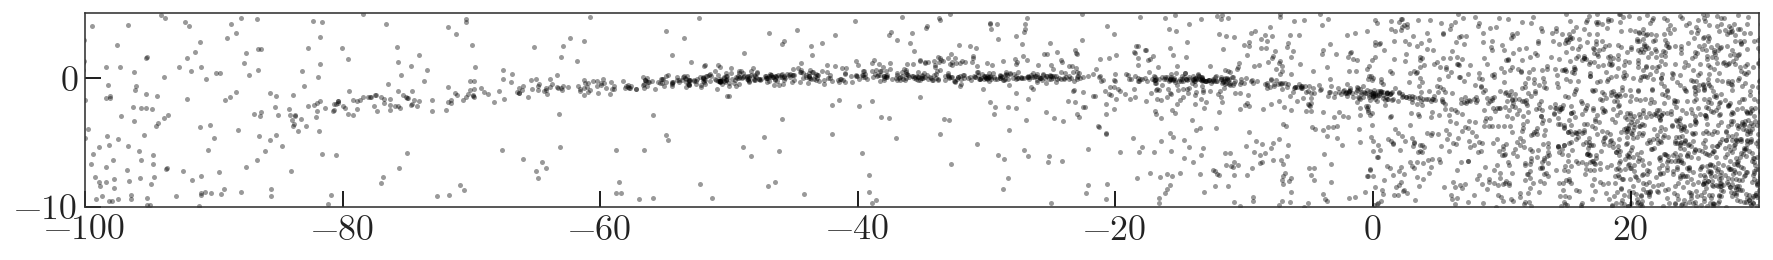

In [530]:
stream_mask = all_cmd_mask & pm_mask

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree[stream_mask],
        c_gd1.phi2.degree[stream_mask], 
        marker='.', linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-100, 30)
ax.set_ylim(-10, 5)

ax.set_aspect('equal')

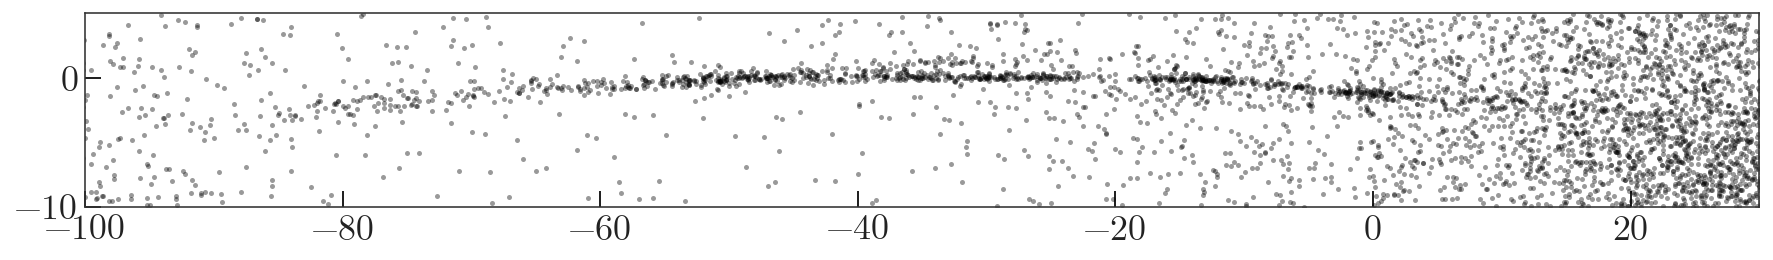

In [221]:
stream_mask = all_cmd_mask & pm_mask

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree[stream_mask],
        c_gd1.phi2.degree[stream_mask], 
        marker='.', linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-100, 30)
ax.set_ylim(-10, 5)

ax.set_aspect('equal')

---

## Significance of spur

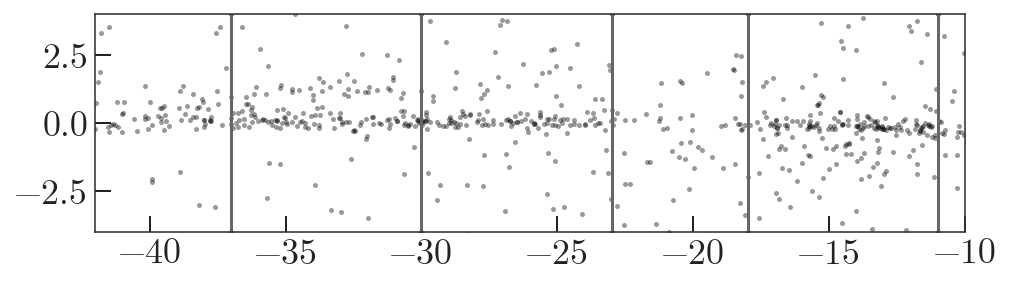

In [512]:
stream_mask = all_cmd_mask & pm_mask

fig, ax = plt.subplots(1, 1, figsize=(15, 2))

ax.plot(c_gd1.phi1.wrap_at(180*u.deg).degree[stream_mask],
        c_gd1.phi2.degree[stream_mask], 
        marker='.', linestyle='none', alpha=0.4, c='k')

ax.set_xlim(-42, -10)
ax.set_ylim(-4, 4)

ax.axvline(-37)
ax.axvline(-30)
ax.axvline(-23)

ax.axvline(-18)
ax.axvline(-11)

ax.set_aspect('equal')

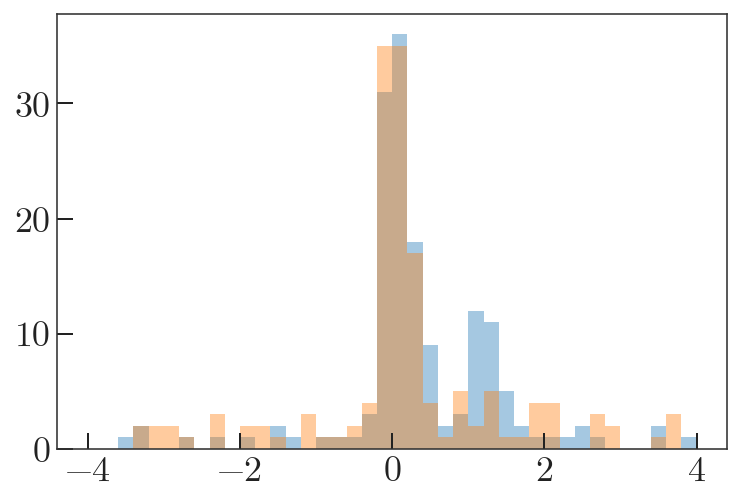

In [506]:
spur_phi1_mask = (phi1 > -37*u.deg) & (phi1 < -30*u.deg)
control_phi1_mask = (phi1 > -30*u.deg) & (phi1 < -23*u.deg)
blob_phi1_mask = (phi1 > -18*u.deg) & (phi1 < -11*u.deg)

bins = np.arange(-4, 4+1e-3, 0.2)
plt.hist(c_gd1.phi2.degree[stream_mask & spur_phi1_mask],
         bins=bins, alpha=0.4);
plt.hist(c_gd1.phi2.degree[stream_mask & control_phi1_mask],
         bins=bins, alpha=0.4);

In [370]:
import emcee
from scipy.special import logsumexp

In [480]:
def lnnormal(x, mu, std):
    return -0.5 * (x-mu)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

def lnprior(p):
    f1, f2, f3, mu1, lnstd1, mu2, lnstd2, lnstd3 = p
    
    lp = 0
    
    fs = [f1, f2, f3]
    for f in fs:
        if f < 0 or f > 1:
            return -np.inf
    
    if f2 > f1:
        return -np.inf
    
    if sum(fs) > 1:
        return -np.inf
    
    if mu1 < -4 or mu1 > 4 or mu2 < -4 or mu2 > 4:
        return -np.inf
    
    lp += lnnormal(lnstd1, -1, 5)
    lp += lnnormal(lnstd2, -1, 5)
    lp += lnnormal(lnstd3, -1, 5)
    
    return lp

def lnlike(p, phi2):
    f1, f2, f3, mu1, lnstd1, mu2, lnstd2, lnstd3 = p
    
    gd1 = lnnormal(phi2, mu1, np.exp(lnstd1))
    gd1_2 = lnnormal(phi2, mu1, np.exp(lnstd3))
    spur = lnnormal(phi2, mu2, np.exp(lnstd2))
    bg = np.full_like(gd1, -np.log(4 - -4))
    
    return logsumexp([gd1, gd1_2, spur, bg], b=np.array([f1, f2, f3, 1-f1-f2-f3])[:, None], axis=0)

def lnprob(p, phi2):
    lp = lnprior(p)
    if not np.all(np.isfinite(lp)):
        return -np.inf
    
    ll = lnlike(p, phi2)
    if not np.all(np.isfinite(ll)):
        return -np.inf
    
    return ll.sum() + lp

In [493]:
phi2 = c_gd1.phi2.degree[stream_mask & spur_phi1_mask]

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


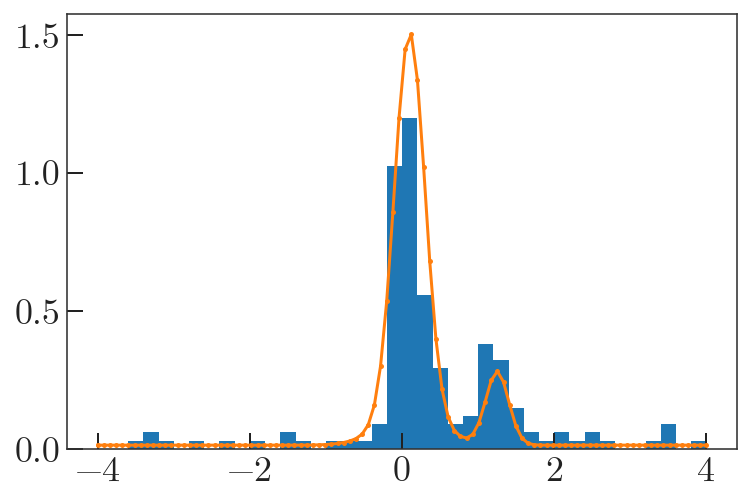

In [494]:
p0 = [0.7, 0.1, 0.1, 
      0.1, np.log(0.2),
      1.25, np.log(0.15),
      np.log(0.4)]

phi2_grid = np.linspace(-4, 4, 100)
plt.hist(phi2, bins=np.arange(-4, 4+1e-3, 0.2), normed=True)
plt.plot(phi2_grid, np.exp(lnlike(p0, phi2_grid)))

In [495]:
nwalkers = 64
p0s = emcee.utils.sample_ball(p0, [1e-3, 1e-2, 1e-2,
                                   1e-1, 1e-3,
                                   1e-1, 1e-3,
                                   1e-3], nwalkers)

In [496]:
sampler = emcee.EnsembleSampler(nwalkers, p0s.shape[1], lnpostfn=lnprob, args=(phi2, ))

In [497]:
_ = sampler.run_mcmc(p0s, 2048)

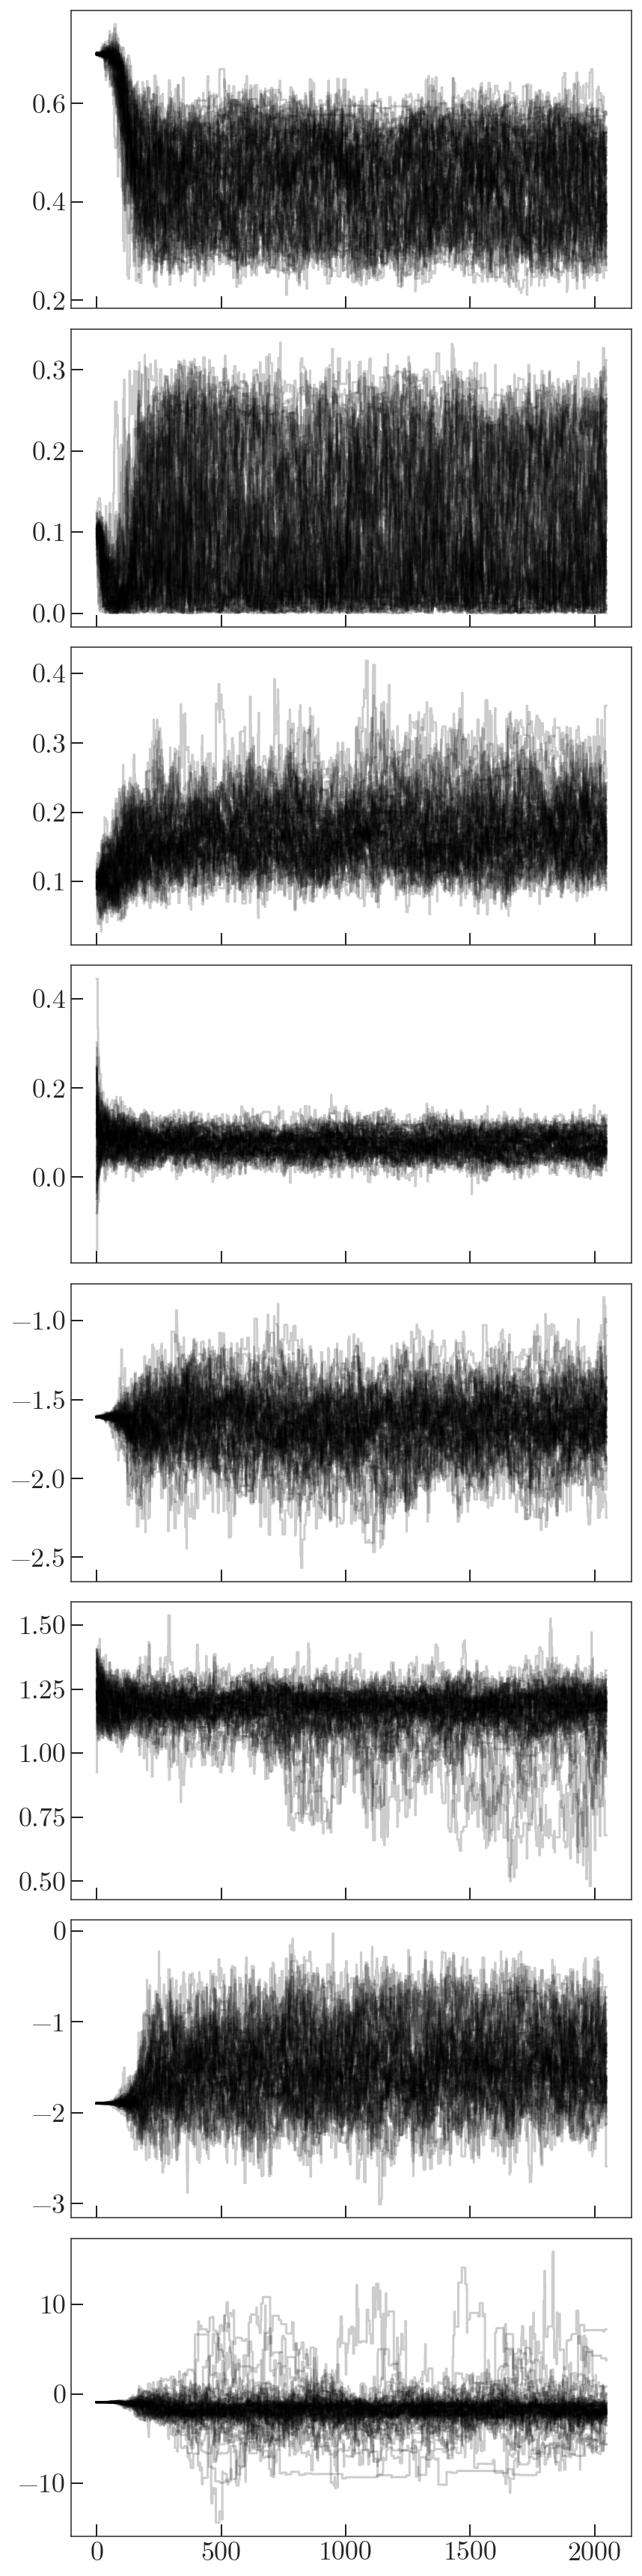

In [498]:
fig, axes = plt.subplots(sampler.dim, 1, 
                         figsize=(6, sampler.dim*3), 
                         sharex=True)

for k in range(sampler.dim):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', drawstyle='steps-mid', 
                     color='k', alpha=0.2)
    
fig.tight_layout()

In [499]:
idx = sampler.lnprobability[:, -1].argmax()
show_p = sampler.chain[idx, -1]

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


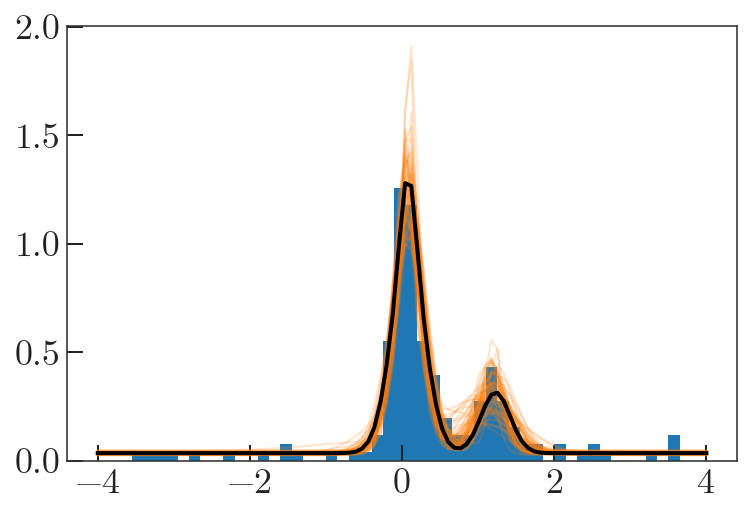

In [500]:
plt.hist(phi2, bins=np.arange(-4, 4+1e-3, 0.15), normed=True)

plt.plot(phi2_grid, np.exp(lnlike(show_p, phi2_grid)), 
         lw=2, marker='', color='k', zorder=100)

for i in range(sampler.chain.shape[0]):
    plt.plot(phi2_grid, np.exp(lnlike(sampler.chain[i, -1], phi2_grid)), 
             lw=1, marker='', alpha=0.2, color='tab:orange')

In [501]:
flatchain = np.vstack(sampler.chain[:, 1024::16])

Text(0.5,0,'$f$')

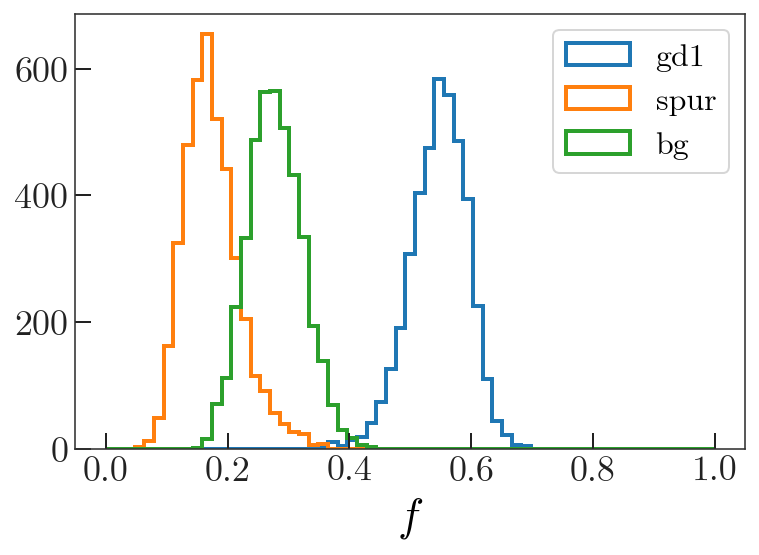

In [511]:
f1, f2, f3, *_ = flatchain.T
f4 = 1 - (f1+f2+f3)
fs = [f1 + f2, f3, f4]
names = ['gd1', 'spur', 'bg']

fig, ax = plt.subplots()
bins = np.linspace(0, 1, 64)
for f, name in zip(fs, names):
    ax.hist(f, bins=bins, histtype='step', 
            label=name, lw=2)
    
ax.legend(fontsize=16)
ax.set_xlabel('$f$')

In [509]:
np.percentile(f3, [1, 99])

array([0.0896273 , 0.31212728])

Text(0.5,0,'$f$')

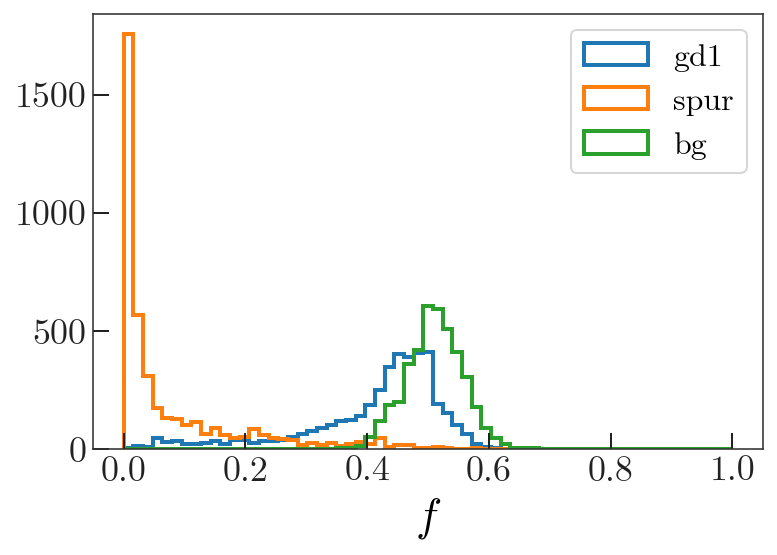

In [492]:
f1, f2, f3, *_ = flatchain.T
f4 = 1 - (f1+f2+f3)
fs = [f1 + f2, f3, f4]
names = ['gd1', 'spur', 'bg']

fig, ax = plt.subplots()
bins = np.linspace(0, 1, 64)
for f, name in zip(fs, names):
    ax.hist(f, bins=bins, histtype='step', 
            label=name, lw=2)
    
ax.legend(fontsize=16)
ax.set_xlabel('$f$')